In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt  #Graphics
from sklearn.ensemble import RandomForestClassifier  #Random Forest algorithm
from sklearn.ensemble import RandomForestRegressor  #Random Forest algorithm
from sklearn.model_selection import train_test_split

### Load the data

Load the MNIST data set from two `.csv` files into two variables. 
Print the number of data points in the training and test sets.
Print the number of object in eacsh class.

In [ ]:
train = pd.read_csv("data/mnist_train.csv")
test = pd.read_csv("data/mnist_test.csv")
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))
print ("Testing dataset has %i observations and %i variables" %(test.shape[0], test.shape[1]))
#Seperate the target and independant variables
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]
#Check the frequency of each number
df_y.value_counts().sort_index()

### Slipt the data

Split the training and test data into two equal parts. In total, we obtain four data sets, 
1. ${\cal D}_{train}$ to train the classifier,
2. ${\cal D}_{val}$ to train the localization function, 
3. ${\cal D}_{cal}$ to compute the quantiles,
4. ${\cal D}_{test}$ to evaluate the predictions sets.

In [12]:
#Split the train dataset
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]
X_train, X_val, y_train, y_val = train_test_split(df_x.to_numpy(dtype=float), 
                                                  df_y.to_numpy(dtype=int), test_size=0.5, random_state=0)
#Split the train dataset
df_x=test.iloc[:,1:]
df_y=test.iloc[:,0]
X_cal, X_test, y_cal, y_test = train_test_split(df_x.to_numpy(dtype=float), 
                                                df_y.to_numpy(dtype=int), test_size=0.5, random_state=0)
print("train:", X_train.shape)
print("test:", X_test.shape)

train: (29999, 784)
test: (5000, 784)


### Train the classifier

Train a Random Forest classifier on ${\cal D}_{train}$.

In [4]:
#training random Forest
rf = RandomForestClassifier(n_estimators=50) 
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

### Evaluate the classifier 

Print the error rate of the classifier on each data set.

In [5]:
probsTrain = rf.predict_proba(X_train)
ERtrain = 1 - sum([1 * (y_train[i] == np.argmax(probsTrain[i])) for i in range(len(probsTrain))])/len(probsTrain)
print("ERtrain =", ERtrain)
probsVal = rf.predict_proba(X_val)
ERval = 1 - sum([1 * (y_val[i] == np.argmax(probsVal[i])) for i in range(len(probsVal))])/len(probsVal)
print("ERval =", ERval)
probsTest = rf.predict_proba(X_test)
ERtest = 1 - sum([1 * (y_test[i] == np.argmax(probsTest[i])) for i in range(len(probsTest))])/len(probsTest)
print("ERtest =", ERtest)

probsTest = rf.predict_proba(X_test)
ERtest = 1 - sum([1 * (y_test[i] == np.argmax(probsTest[i])) for i in range(len(probsTest))])/len(probsTest)
print("ERtest =", ERtest)

ERval = 0.03976666666666662
ERtest = 0.03500000000000003


### Train the localizer

Compute the conformity scores and train a model, $g(f(X))$, that minimizes
$$ {\rm E} |A - g(f(X))|^2$$
where $A = 1 - f_Y(X)$ and $f(X)\in [0, 1]^{10}$ is the output of the classifier.

In [8]:
#training random Forest
probsVal = rf.predict_proba(X_val)
Aval = np.array([1 - probsVal[i][y_val[i]] for i in range(len(y_val))])
g=RandomForestRegressor(n_estimators=50) 
g.fit(probsVal, Aval)

RandomForestRegressor(n_estimators=50)

### Compute the quantiles

Compute the quantiles of the original and transformed conformity scores on the calibration set. 
The transformed conformity score is 
$$ B = A - g(f(X))$$
where $g$ is the trained localization function. Check the performance of $g$ by comparing its output with $A$.

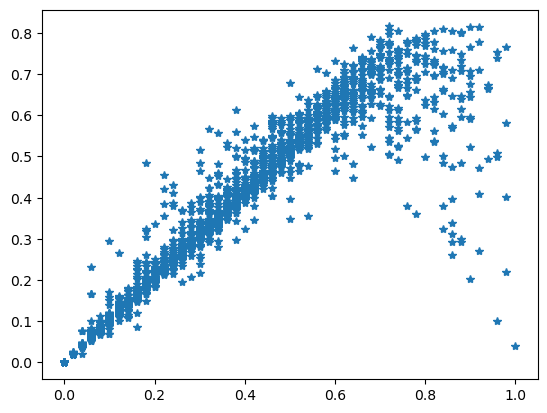

In [13]:
probsCal = rf.predict_proba(X_cal)
AcalPredict = g.predict(probsCal)
y_cal = [int(y) for y in y_cal]
Acal = np.array([1 - probsCal[i][y_cal[i]] for i in range(len(y_cal))])
Bcal = Acal - AcalPredict
plt.plot(Acal, AcalPredict, '*')
alpha = .05
QB = np.sort(Bcal)[int(np.ceil((len(Bcal) + 1) * (1 - alpha)))]
QA = np.sort(Acal)[int(np.ceil((len(Acal) + 1) * (1 - alpha)))]



### Prediction sets

Compute the prediction sets from $Q_A$ and $Q_B$ for all test samples.
Let $n$ be
1. a True Positive if $y \in C_n$ and $y = y_n$,,
2. a False Positive if $y \in C_n$ but $y \neq y_n$,
3. a True Negative if $y \notin C_n$ and $y \neq y_n$, and
4. a False Negative if $y \notin C_n$ but $y \neq y_n$.

Compute the number of TP, FP, TN, and FN for $C_A$ and $ 

In [11]:
probsTest = rf.predict_proba(X_test)
AtestPredict = g.predict(probsTest)
y_test = [int(y) for y in y_test]
Atest = np.array([[1 - probsTest[i][j] for j in range(len(probsTest[i]))] for i in range(len(probsTest))])
Btest = np.array([[1 - probsTest[i][j] - AtestPredict[i] for j in range(len(probsTest[i]))] for i in range(len(probsTest))]) 
print(Atest.shape)
print(Btest.shape)
intervalsA = [[j for j in range(len(probsTest[i])) if Atest[i][j] <= QA] for i in range(len(probsTest))]
intervalsB = [[j for j in range(len(probsTest[i])) if Btest[i][j] <= QB] for i in range(len(probsTest))]

TP, FP, TN, FN = [0, 0], [0, 0],[0, 0], [0, 0]
for i in range(len(intervalsA)):
    intervals = intervalsA[i], intervalsB[i]
    y = y_test[i]
    for iModel in [0, 1]:
        positives = [1 for j in range(10) if j in intervals[iModel]]
        TP[iModel] = TP[iModel] + sum([1 for j in positives if j == y])
        FP[iModel] = FP[iModel] + sum([1 for j in positives if j != y])
        negatives = [1 for j in range(10) if j not in intervals[iModel]]
        TN[iModel] = TN[iModel] + sum([1 for j in negatives if j != y]) 
        FN[iModel] = FN[iModel] + sum([1 for j in negatives if j == y]) 
print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
ERtest = sum([1 * (y_test[i] == np.argmax(probsTest[i])) for i in range(len(probsTest))])/len(probsTest)
print("ER:", ERtest)

for i in range(len(intervalsA)):
    if (len(intervalsA[i]) != len(intervalsB[i])):
        print("CA, CB, y: ", intervalsA[i], intervalsB[i], y_test[i])


(5000, 10)
(5000, 10)
TP= [557, 555]
FP= [4446, 4419]
TN= [39944, 39971]
FN= [5053, 5055]
ER: 0.965
CA, CB, y:  [3, 8] [3] 3
CA, CB, y:  [4, 6] [] 6
CA, CB, y:  [9] [3, 9] 7
CA, CB, y:  [] [5] 3
CA, CB, y:  [] [2, 8] 8
CA, CB, y:  [4, 9] [9] 4
CA, CB, y:  [] [8] 8
CA, CB, y:  [9] [8, 9] 8
CA, CB, y:  [] [2, 8] 9
CA, CB, y:  [3] [] 3
CA, CB, y:  [] [5] 6
CA, CB, y:  [] [6] 6
CA, CB, y:  [2] [] 2
CA, CB, y:  [2, 7] [] 2
CA, CB, y:  [] [1, 3, 8] 8
CA, CB, y:  [5] [3, 5] 5
CA, CB, y:  [1, 7] [] 7
CA, CB, y:  [] [1] 1
CA, CB, y:  [3, 5] [3] 3
CA, CB, y:  [2] [] 2
CA, CB, y:  [7] [] 7
CA, CB, y:  [3, 5] [5] 5
CA, CB, y:  [4, 6] [] 6
CA, CB, y:  [] [8, 9] 8
CA, CB, y:  [2] [] 2
CA, CB, y:  [] [3, 5] 3
CA, CB, y:  [7, 9] [7] 7
CA, CB, y:  [] [8] 7
CA, CB, y:  [5, 9] [5] 5
CA, CB, y:  [3, 5] [3] 3
CA, CB, y:  [2, 8] [2] 2
CA, CB, y:  [1] [] 1
CA, CB, y:  [2] [2, 3] 2
CA, CB, y:  [0] [] 0
CA, CB, y:  [] [9] 9
CA, CB, y:  [] [2] 0
CA, CB, y:  [2, 7] [7] 7
CA, CB, y:  [3, 5] [3] 3
CA, CB, y:  [0] 

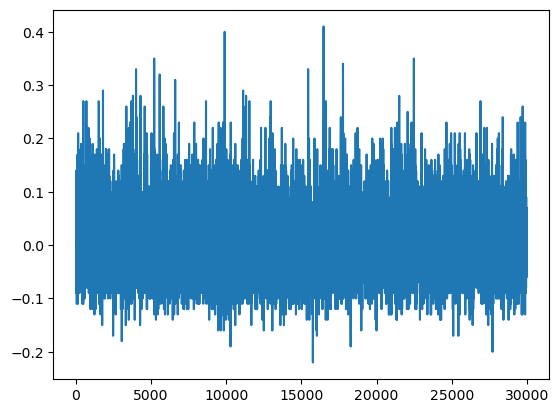

In [34]:
plt.plot(A - Apredict)

(1000, 1)


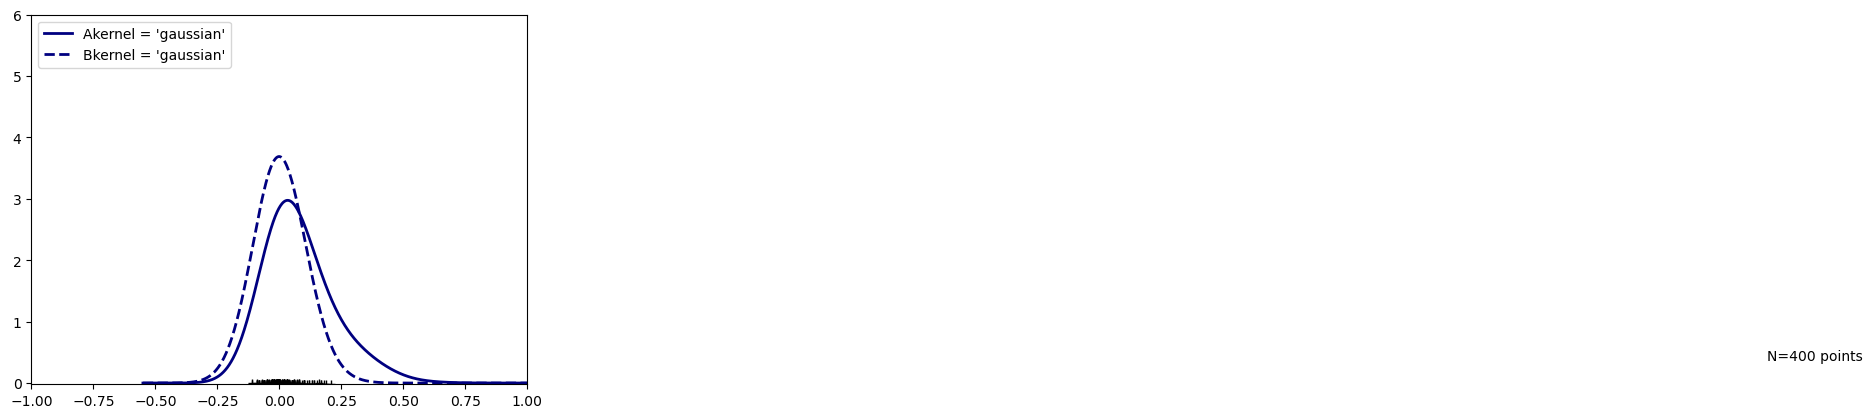

In [61]:
# from scipy.stats import norm
from sklearn.neighbors import KernelDensity
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian"]#, "tophat", "epanechnikov"]
lw = 2

N = 400
B = A - Apredict
b = B[:N].reshape(N, 1)
a = numpy.array(A[:N]).reshape(N, 1)

X_plot = np.linspace(5 * min(b), 5 * max(b), 1000).reshape(1000, 1)
print(X_plot.shape)

lines = ["-", "--"]
names = ["A", "B"]
for iSamples in [0, 1]:
    for color, kernel in zip(colors, kernels):
        if iSamples:
            kde = KernelDensity(kernel=kernel, bandwidth=0.1).fit(b)
        else:
            kde = KernelDensity(kernel=kernel, bandwidth=0.1).fit(a)
        log_dens = kde.score_samples(X_plot)
        plt.plot(
            X_plot[:, 0],
            np.exp(log_dens),
            color=color,
            lw=lw,
            linestyle=lines[iSamples],
            label=names[iSamples]+"kernel = '{0}'".format(kernel),
        )

plt.text(6, 0.38, "N={0} points".format(N))

plt.legend(loc="upper left")
plt.plot(b[:, 0], -0.005 - 0.01 * np.random.random(b.shape[0]), "+k")

plt.xlim(-1, 1)
plt.ylim(-0.02, 6)
plt.show()

In [ ]:
numpy.random.seed(1234)
N = 20
R = 100
eps= .6

p1, p2 = 0, 0

def linearModel(x, w):
    return x @ w
    
def sigmoid(t):
    return 1/(1 + numpy.exp(-t))


maxDist = 8
Xd = maxDist * numpy.array([.01 + x/R for x in range(R)]).reshape([R, 1])
maxPrice = 10
Xp = maxPrice * numpy.array([.01 + x/R for x in range(R)]).reshape([R, 1])

#data shuffling
shuffle = numpy.random.choice(len(Xd), size=len(Xd)) 
Xps = Xp[shuffle]
Z = numpy.concatenate((numpy.power(Xd, 0), Xd, Xps), axis=1)
Z2 = numpy.concatenate((numpy.power(Xd, 0), Xd, Xps, Xd * Xps), axis=1)
wSold = [-3, .2, .1 , 0.3]
S2 = linearModel(Z2, wSold)
sold = ((sigmoid(S2) + abs(S2) * eps * numpy.random.randn())> 1/2) * 1
choice = numpy.random.choice(R, size=N, replace =False)
Zdata = Z[choice]
Z2data = Z2[choice]
S2data = S2[choice]
soldData = sold[choice]
markers = ['bo' if x else 'ro' for x in soldData]
unsoldIndexes = [i for i in range(len(soldData)) if soldData[i]]
soldIndexes = [i for i in range(len(soldData)) if soldData[i] == 0]
#grid
Grid = numpy.concatenate([numpy.concatenate((numpy.power(Xd, 0), xd * numpy.ones([len(Xd), 1]), Xp, xd * Xp), axis=1) for xd in Xd], axis = 0)
print(Grid.shape)
Sgrid = linearModel(Grid, wSold)
soldGrid = ((sigmoid(Sgrid))> 1/2) * 1
unsoldIndGrid = [i for i in range(len(soldGrid)) if soldGrid[i]]
soldIndGrid = [i for i in range(len(soldGrid)) if soldGrid[i] == 0]

if p2:
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('distance from the city centre')
    plt.ylabel('price')
    plt.plot(Grid[soldIndGrid, 1], Grid[soldIndGrid, 2], 'bo', alpha=.4, 
            label='unknown model (sold)')
    plt.plot(Grid[unsoldIndGrid, 1], Grid[unsoldIndGrid, 2], 'ro', alpha=.4, 
            label='unknown model (unsold)')

    plt.plot(Zdata[soldIndexes, 1], Zdata[soldIndexes, 2], '*k', alpha=.9, 
            label='sold houses')
    plt.plot(Zdata[unsoldIndexes, 1], Zdata[unsoldIndexes, 2], 'ok', alpha=.9, 
            label='unsold houses')

    plt.legend()
    plt.savefig('pics/w4logisticDataGrid.pdf')
    plt.show()




In [8]:
def loglikelihood(w, Z):
    X, Y = Z
    F = sigmoid(linearModel(X, w))
    Fprime = F * (1 - F)
    f = - numpy.log(Y * F + (1 - Y) * (1 - F) )
    df = -1/(Y * F + (1 - Y) * (1 - F) ) * (2 * Y - 1) * Fprime * X
    return f, df

XfData = Zdata[:, :2]
YfData = soldData.reshape([len(YfData), 1]) 
ZfData = XfData, YfData
w0 = numpy.random.randn(2)
f, df = loglikelihood(w0, ZfData)
print(f, df)


ValueError: operands could not be broadcast together with shapes (20,20) (20,2) 